## 0) Prerequisites: Pip Installs

In [1]:
# Install deps (Colab)
!pip -q install feast==0.58.0 s3fs boto3 pyarrow pandas scikit-learn "mlflow>=2.12,<3" "dagshub==0.6.4" "dvc[s3]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.5/

## 1) Credentials / Environment
Set these using Colab `userdata` (or replace with your own method).

In [2]:
import os
from google.colab import userdata

# AWS
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION') or 'us-east-1'

# MLflow (DAGsHub)
os.environ["DAGSHUB_USER_TOKEN"] = userdata.get('DAGSHUB_TOKEN')

missing = [k for k in ['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','DAGSHUB_USER_TOKEN'] if not os.environ.get(k)]
if missing:
    raise ValueError(f"Missing secrets in Colab userdata: {missing}")
print('Secrets loaded:', ', '.join(['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','AWS_DEFAULT_REGION','DAGSHUB_USER_TOKEN']))

Secrets loaded: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_DEFAULT_REGION, DAGSHUB_USER_TOKEN


## 2) Setup + DVC pull

In [3]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

REPO_NAME = "dissertation"  # change if needed
REPO_URL = f"https://github.com/Roncool13/{REPO_NAME}.git"
BRANCH_OR_COMMIT = "main"  # or a specific commit hash for perfect reproducibility

if not Path(REPO_NAME).exists():
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git checkout {BRANCH_OR_COMMIT}
!git status

!dvc pull -q
print("DVC pull done ✅")

Cloning into 'dissertation'...
remote: Enumerating objects: 1008, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 1008 (delta 78), reused 100 (delta 40), pack-reused 864 (from 1)
Receiving objects: 100% (1008/1008), 615.42 KiB | 7.99 MiB/s, done.
Resolving deltas: 100% (623/623), done.
/content/dissertation
Already on 'main'
Your branch is up to date with 'origin/main'.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
DVC pull done ✅


## 3) MLflow Setup

In [4]:
import mlflow
import dagshub

dagshub.init(repo_owner='Roncool13', repo_name='dissertation-mlflow', mlflow=True)
mlflow.set_experiment("dissertation-fusion-prediction-multisym-2019-23")
mlflow.sklearn.autolog(disable=True)

print('MLflow tracking URI:', mlflow.get_tracking_uri())


Accessing as Roncool13

Initialized MLflow to track repo "Roncool13/dissertation-mlflow"

Repository Roncool13/dissertation-mlflow initialized!

MLflow tracking URI: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow


## 4) Load datasets + metadata + label name

In [5]:
import json
import pandas as pd
from pathlib import Path

meta_ohlcv = json.loads(Path("data/features/ohlcv_feature_metadata.json").read_text())

# Horizon + label col (prefer explicit label col from metadata; fallback to y_up_{h}d)
horizon_days = int(meta_ohlcv.get("horizon_days", meta_ohlcv.get("labeling", {}).get("horizon_days", 5)))
label_col = (
    meta_ohlcv.get("labeling", {}).get("label_col")
    or meta_ohlcv.get("labeling", {}).get("label_col_name")
    or f"y_up_{horizon_days}d"
)

ohlcv = pd.read_parquet("data/features/ohlcv_features.parquet")
sent  = pd.read_parquet("data/features/news_sentiment_features.parquet")
pat   = pd.read_parquet("data/features/pattern_features.parquet")
news_meta = json.loads(Path("data/features/news_sentiment_feature_metadata.json").read_text())

for df in (ohlcv, sent, pat):
    df["date"] = pd.to_datetime(df["date"])

assert label_col in ohlcv.columns, f"{label_col} not found in ohlcv_features"
print("Using label:", label_col)


Using label: y_up_5d


## 5) Build X columns for each expert

### 5.1) OHLCV X columns

In [6]:
# Exclude forward-looking columns to prevent leakage (matches your OHLCV notebook idea)
exclude_prefixes = ("close_fwd_", "ret_fwd_")
exclude_cols = {"symbol", "date", label_col}

ohlcv_X_cols = [
    c for c in ohlcv.columns
    if c not in exclude_cols and not c.startswith(exclude_prefixes)
]
print("OHLCV feature count:", len(ohlcv_X_cols))

OHLCV feature count: 85


### 5.2) Sentiment X columns (Building Gated Sentiment for 1 day lag)

In [7]:
# Sentiment feature columns (exclude keys + any label column if present)
label_col_from_news = news_meta.get("supervision", {}).get("label_col_name", None)
sent_exclude = {"symbol", "date"}
if label_col_from_news:
    sent_exclude.add(label_col_from_news)

sent_X_cols = [c for c in sent.columns if c not in sent_exclude]
print("Sentiment feature count:", len(sent_X_cols))


Sentiment feature count: 52


### 5.3) Pattern X columns (+ shift by 1 day)

In [8]:
# Pattern features: avoid double-shift if already lagged by pipeline
pat_exclude = {"symbol", "date"}
pat_X_cols = [c for c in pat.columns if c not in pat_exclude]

pat = pat.sort_values(["symbol","date"]).reset_index(drop=True)

already_lagged = any(("_lag_" in c) or ("_roll_" in c) for c in pat_X_cols)
if already_lagged:
    print("Skipping pattern shift: lag/roll columns detected (assumed leakage-safe).")
else:
    pat[pat_X_cols] = pat.groupby("symbol", sort=False)[pat_X_cols].shift(1)
    print("Applied pattern shift(1) to prevent same-day leakage.")

print("Pattern feature count:", len(pat_X_cols))


Applied pattern shift(1) to prevent same-day leakage.
Pattern feature count: 17


In [9]:
# ---------- Build df with a SINGLE label source (avoid _x/_y collisions) ----------
# If label exists in BOTH, drop from sentiment to avoid merge collisions.
if label_col in sent.columns and label_col in ohlcv.columns:
    print(f"Label column {label_col} found in both sentiment and OHLCV. Dropping it from sentiment to avoid clash.")
    sent = sent.drop(columns=[label_col])
    # Re-define sent_X_cols after dropping the label column
    sent_X_cols = [c for c in sent.columns if c not in {"symbol","date"}]

assert label_col in ohlcv.columns, f"{label_col} not found in ohlcv_features"
assert label_col not in sent.columns, f"{label_col} found in sentiment_features even after dropping"
print(f"Sentiment feature count after label handling: {len(sent_X_cols)}")


Sentiment feature count after label handling: 52


## 6) Merge all on (symbol, date) + create splits from OHLCV metadata

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [11]:
# Keep label and key from OHLCV (full market timeline)
label_df = ohlcv[["symbol","date",label_col]].dropna().copy()

# Merge:
# - OHLCV features: inner (must exist if label exists)
# - Sentiment/pattern: LEFT so days with no news/pattern won't be dropped
df = label_df.merge(
    ohlcv[["symbol","date"] + ohlcv_X_cols], on=["symbol","date"], how="inner"
).merge(
    sent[["symbol","date"] + sent_X_cols], on=["symbol","date"], how="left"
).merge(
    pat[["symbol","date"] + pat_X_cols], on=["symbol","date"], how="left"
)

# Fill missing expert features with 0 (no-news/no-pattern days)
for c in sent_X_cols + pat_X_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0.0)

df = df.sort_values(["symbol","date"]).reset_index(drop=True)
# Drop any remaining NaNs (should be only if OHLCV has NaNs)
df = df.dropna(subset=[label_col] + ohlcv_X_cols).reset_index(drop=True)

print("Merged rows:", len(df))
print("Date min/max:", df["date"].min(), df["date"].max())


Merged rows: 25116
Date min/max: 2019-02-22 00:00:00 2023-12-21 00:00:00


In [12]:
sent.columns.tolist()

['symbol',
 'date',
 'article_count',
 'pos_count',
 'neg_count',
 'neu_count',
 'highrel_count',
 'rel_score_mean',
 'sent_conf_mean',
 'polarity_mean',
 'polarity_wmean',
 'pos_ratio',
 'neg_ratio',
 'neu_ratio',
 'highrel_ratio',
 'polarity_wmean_lag_1',
 'polarity_mean_lag_1',
 'pos_ratio_lag_1',
 'neg_ratio_lag_1',
 'article_count_lag_1',
 'highrel_ratio_lag_1',
 'rel_score_mean_lag_1',
 'polarity_wmean_lag_2',
 'polarity_mean_lag_2',
 'pos_ratio_lag_2',
 'neg_ratio_lag_2',
 'article_count_lag_2',
 'highrel_ratio_lag_2',
 'rel_score_mean_lag_2',
 'polarity_wmean_lag_3',
 'polarity_mean_lag_3',
 'pos_ratio_lag_3',
 'neg_ratio_lag_3',
 'article_count_lag_3',
 'highrel_ratio_lag_3',
 'rel_score_mean_lag_3',
 'polarity_wmean_lag_4',
 'polarity_mean_lag_4',
 'pos_ratio_lag_4',
 'neg_ratio_lag_4',
 'article_count_lag_4',
 'highrel_ratio_lag_4',
 'rel_score_mean_lag_4',
 'polarity_wmean_lag_5',
 'polarity_mean_lag_5',
 'pos_ratio_lag_5',
 'neg_ratio_lag_5',
 'article_count_lag_5',
 'high

In [13]:
def _parse_date(s):
    return pd.to_datetime(s) if s else None

splits = meta_ohlcv.get("splits", {})

# Support BOTH metadata formats:
# 1) legacy: train_start/train_end/val_start/val_end/test_start/test_end
# 2) new: splits = {train:{start,end}, val:{start,end}, test:{start,end}}
def _get_split(name):
    if f"{name}_start" in splits:
        return {"start": splits.get(f"{name}_start"), "end": splits.get(f"{name}_end")}
    if name in splits and isinstance(splits[name], dict):
        return splits[name]
    return None

tr = _get_split("train")
va = _get_split("val")
te = _get_split("test")

if tr and va and te and tr.get("start") and tr.get("end") and va.get("start") and va.get("end") and te.get("start"):
    train_start = _parse_date(tr["start"]); train_end = _parse_date(tr["end"])
    val_start   = _parse_date(va["start"]); val_end   = _parse_date(va["end"])
    test_start  = _parse_date(te["start"]); test_end  = _parse_date(te.get("end"))

    train_df = df[(df["date"]>=train_start) & (df["date"]<=train_end)].copy()
    val_df   = df[(df["date"]>=val_start)   & (df["date"]<=val_end)].copy()
    test_df  = df[(df["date"]>=test_start)  & ((df["date"]<=test_end) if test_end is not None else True)].copy()
else:
    # Fallback: year splits (not preferred)
    yrs = df["date"].dt.year
    train_df = df[yrs==2019].copy()
    val_df   = df[yrs==2022].copy()
    test_df  = df[yrs==2023].copy()

print("train rows", len(train_df), train_df["date"].min(), train_df["date"].max(), "pos_rate", float(train_df[label_col].mean()))
print("val rows", len(val_df), val_df["date"].min(), val_df["date"].max(), "pos_rate", float(val_df[label_col].mean()))
print("test rows", len(test_df), test_df["date"].min(), test_df["date"].max(), "pos_rate", float(test_df[label_col].mean()))


train rows 14847 2019-02-22 00:00:00 2021-12-31 00:00:00 pos_rate 0.5275813295615276
val rows 5208 2022-01-03 00:00:00 2022-12-30 00:00:00 pos_rate 0.5276497695852534
test rows 5061 2023-01-02 00:00:00 2023-12-21 00:00:00 pos_rate 0.5633274056510571


In [14]:
# Sanity checks: alignment across modalities + leakage guardrails
import numpy as np
import pandas as pd

# 1) Keys must be unique and sorted
assert df[['symbol','date']].isna().sum().sum() == 0, "Nulls in (symbol,date)"
assert not df.duplicated(['symbol','date']).any(), "Duplicate (symbol,date) rows found"
df = df.sort_values(['symbol','date']).reset_index(drop=True)

# 2) Feature sets exist and are non-empty
for name, cols in [('OHLCV', ohlcv_X_cols), ('SENT', sent_X_cols), ('PAT', pat_X_cols)]:
    missing = [c for c in cols if c not in df.columns]
    assert len(missing) == 0, f"{name} missing columns: {missing[:10]} (showing first 10)"
    assert len(cols) > 0, f"{name} has 0 features"

# 3) Split frames must be perfectly aligned by construction (they come from df masks),
# but we still verify shapes and key hashes so any accidental reordering is caught.
def _key_hash(frame: pd.DataFrame) -> str:
    # stable hash of (symbol,date) order
    return pd.util.hash_pandas_object(frame[['symbol','date']], index=False).astype('uint64').sum().__str__()

for name, part in [('train', train_df), ('val', val_df), ('test', test_df)]:
    assert part[['symbol','date']].isna().sum().sum() == 0
    assert not part.duplicated(['symbol','date']).any()
    print(f"{name}: rows={len(part)} key_hash={_key_hash(part)} "
          f"pos_rate={float(part[label_col].mean()):.4f} "
          f"date_min={part['date'].min().date()} date_max={part['date'].max().date()}")

# 4) Leakage sanity: features are shifted already, but we still ensure no forward-looking columns sneak in
leaky = [c for c in df.columns if c.startswith(('close_fwd_', 'ret_fwd_'))]
assert len(leaky) == 0, f"Forward-looking columns present in df: {leaky[:10]}"


train: rows=14847 key_hash=12496410802723324887 pos_rate=0.5276 date_min=2019-02-22 date_max=2021-12-31
val: rows=5208 key_hash=8155048135365295115 pos_rate=0.5276 date_min=2022-01-03 date_max=2022-12-30
test: rows=5061 key_hash=13396403608354605899 pos_rate=0.5633 date_min=2023-01-02 date_max=2023-12-21


## 7) Load expert models from MLflow Registry

In [15]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

client = MlflowClient()

def load_model_version(model_name: str, version: int = None):
    if version is None:
        versions = client.search_model_versions(f"name='{model_name}'")
        if not versions:
            raise ValueError(f"No registered model versions found for: {model_name}")
        v = max(int(m.version) for m in versions)
    else:
        v = version

    uri = f"models:/{model_name}/{v}"
    print(f"Loading {model_name} v{v} -> {uri}")

    try:
        model = mlflow.sklearn.load_model(uri)
        model_kind = "sklearn"
    except Exception as e:
        print(f"mlflow.sklearn.load_model failed ({e}); falling back to pyfunc")
        model = mlflow.pyfunc.load_model(uri)
        model_kind = "pyfunc"

    return model, model_kind, uri

# ---- Configure registered model names here ----
MODEL_OHLCV = "ohlcv_lr_multisym_2019_2023_persymnorm_true"
MODEL_SENT  = "sentiment_lr_baseline_multisym"
MODEL_PAT   = "pattern_lr_multisym_2019_2023"

# Optionally pin versions (recommended for reproducibility); set to None to use latest.
VER_OHLCV = None
VER_SENT  = 3
VER_PAT   = None

m_ohlcv, kind_ohlcv, uri_ohlcv = load_model_version(MODEL_OHLCV, VER_OHLCV)
m_sent,  kind_sent,  uri_sent  = load_model_version(MODEL_SENT,  VER_SENT)
m_pat,   kind_pat,   uri_pat   = load_model_version(MODEL_PAT,   VER_PAT)


Loading ohlcv_lr_multisym_2019_2023_persymnorm_true v1 -> models:/ohlcv_lr_multisym_2019_2023_persymnorm_true/1


Loading sentiment_lr_baseline_multisym v3 -> models:/sentiment_lr_baseline_multisym/3


Loading pattern_lr_multisym_2019_2023 v1 -> models:/pattern_lr_multisym_2019_2023/1


## 8) Generate expert probabilities (meta features)

In [16]:
# OOF helper for time-series stacking (date-grouped expanding-window CV)
import numpy as np
from sklearn.base import clone

def _ensure_series(y):
    try:
        import pandas as pd
        if isinstance(y, (pd.Series, pd.DataFrame)):
            return y.squeeze()
    except Exception:
        pass
    return y

class DateGroupedSplit:
    """Expanding-window split by unique dates to avoid splitting within the same trading day across symbols."""
    def __init__(self, dates, n_splits=5):
        self.dates = np.asarray(dates)
        self.n_splits = n_splits

    def split(self):
        uniq = np.unique(self.dates)
        if len(uniq) < (self.n_splits + 1):
            # Fallback: behave like a single split
            cut = max(1, int(0.8 * len(uniq)))
            tr_dates = uniq[:cut]
            te_dates = uniq[cut:]
            tr = np.where(np.isin(self.dates, tr_dates))[0]
            te = np.where(np.isin(self.dates, te_dates))[0]
            yield tr, te
            return

        edges = np.linspace(0, len(uniq), self.n_splits + 2, dtype=int)
        for i in range(self.n_splits):
            tr_dates = uniq[:edges[i+1]]
            te_dates = uniq[edges[i+1]:edges[i+2]]
            tr = np.where(np.isin(self.dates, tr_dates))[0]
            te = np.where(np.isin(self.dates, te_dates))[0]
            yield tr, te

def oof_proba_dategrouped(estimator, X, y, dates, n_splits=5):
    """Out-of-fold probabilities using date-grouped expanding splits."""
    y = _ensure_series(y)
    n = len(y)
    oof = np.full(n, np.nan, dtype=float)

    splitter = DateGroupedSplit(dates=dates, n_splits=n_splits)

    for fold, (tr, te) in enumerate(splitter.split()):
        y_tr = y.iloc[tr] if hasattr(y, "iloc") else y[tr]
        if len(np.unique(y_tr)) < 2:
            continue

        m = clone(estimator)
        X_tr = X.iloc[tr] if hasattr(X, "iloc") else X[tr]
        X_te = X.iloc[te] if hasattr(X, "iloc") else X[te]
        m.fit(X_tr, y_tr)
        oof[te] = m.predict_proba(X_te)[:, 1]

    valid_mask = ~np.isnan(oof)
    return oof, valid_mask


In [17]:
import numpy as np
import pandas as pd

def get_expected_cols(model):
    # Direct estimator
    cols = getattr(model, "feature_names_in_", None)
    if cols is not None:
        return list(cols)

    # Pipeline: check steps for feature_names_in_
    if hasattr(model, "named_steps"):
        for step in reversed(list(model.named_steps.values())):
            cols = getattr(step, "feature_names_in_", None)
            if cols is not None:
                return list(cols)

    return None  # fallback: unknown

def align_X(df: pd.DataFrame, model, fallback_cols=None, name="model"):
    exp = get_expected_cols(model)
    if exp is None:
        if fallback_cols is None:
            raise ValueError(f"{name}: couldn't infer expected columns and no fallback_cols provided.")
        exp = list(fallback_cols)

    missing = [c for c in exp if c not in df.columns]
    if missing:
        raise ValueError(f"{name}: missing required columns: {missing[:20]} (showing 20). "
                         f"Example df cols: {list(df.columns)[:20]}")

    # Keep exact order model expects
    return df[exp].copy(), exp

In [18]:
print("OHLCV expects symbol?", "symbol" in (get_expected_cols(m_ohlcv) or []))
print("SENT expects symbol?",  "symbol" in (get_expected_cols(m_sent) or []))
print("PAT expects symbol?",   "symbol" in (get_expected_cols(m_pat) or []))

OHLCV expects symbol? True
SENT expects symbol? False
PAT expects symbol? True


In [19]:
# Generate expert probabilities (meta features) - OOF-safe for TRAIN
import numpy as np
import pandas as pd
from sklearn.base import clone

def _assert_aligned(df_base, cols, name):
    if len(df_base) == 0:
        raise ValueError(f"{name}: empty dataframe.")
    if df_base[cols].isna().any().any():
        nan_cols = df_base[cols].columns[df_base[cols].isna().any()].tolist()
        raise ValueError(f"{name}: NaNs found in feature columns: {nan_cols[:10]} (showing up to 10).")

# --- Build X matrices aligned to each expert's training schema ---
X_ohlcv_train, ohlcv_used_cols = align_X(train_df, m_ohlcv, fallback_cols=ohlcv_X_cols, name="OHLCV")
X_sent_train,  sent_used_cols  = align_X(train_df, m_sent,  fallback_cols=sent_X_cols,  name="SENT")
X_pat_train,   pat_used_cols   = align_X(train_df, m_pat,   fallback_cols=pat_X_cols,   name="PAT")

y_train     = train_df[label_col].astype(int).copy()
dates_train = train_df["date"].to_numpy()

X_ohlcv_val, _ = align_X(val_df, m_ohlcv, fallback_cols=ohlcv_X_cols, name="OHLCV/VAL")
X_sent_val,  _ = align_X(val_df, m_sent,  fallback_cols=sent_X_cols,  name="SENT/VAL")
X_pat_val,   _ = align_X(val_df, m_pat,   fallback_cols=pat_X_cols,   name="PAT/VAL")
y_val          = val_df[label_col].astype(int).copy()

X_ohlcv_test, _ = align_X(test_df, m_ohlcv, fallback_cols=ohlcv_X_cols, name="OHLCV/TEST")
X_sent_test,  _ = align_X(test_df, m_sent,  fallback_cols=sent_X_cols,  name="SENT/TEST")
X_pat_test,   _ = align_X(test_df, m_pat,   fallback_cols=pat_X_cols,   name="PAT/TEST")
y_test          = test_df[label_col].astype(int).copy()

print("OHLCV cols used:", len(ohlcv_used_cols), "| includes symbol:", "symbol" in ohlcv_used_cols)
print("SENT  cols used:", len(sent_used_cols),  "| includes symbol:", "symbol" in sent_used_cols)
print("PAT   cols used:", len(pat_used_cols),   "| includes symbol:", "symbol" in pat_used_cols)

_assert_aligned(train_df, ohlcv_X_cols, "OHLCV/train")
_assert_aligned(train_df, sent_X_cols,  "Sentiment/train")
_assert_aligned(train_df, pat_X_cols,   "Pattern/train")

# (A) OOF predictions for TRAIN (meta-train) using date-grouped expanding-window splits
N_SPLITS_OOF = 5
p_ohlcv_train_oof, m1 = oof_proba_dategrouped(m_ohlcv, X_ohlcv_train, y_train, dates_train, n_splits=N_SPLITS_OOF)
p_sent_train_oof,  m2 = oof_proba_dategrouped(m_sent,  X_sent_train,  y_train, dates_train, n_splits=N_SPLITS_OOF)
p_pat_train_oof,   m3 = oof_proba_dategrouped(m_pat,   X_pat_train,   y_train, dates_train, n_splits=N_SPLITS_OOF)

valid_oof = (m1 & m2 & m3)
dropped = int((~valid_oof).sum())
print(f"OOF coverage: {valid_oof.mean():.3f} (dropping {dropped} earliest train rows with no OOF coverage)")

meta_train = pd.DataFrame(
    {"p_ohlcv": p_ohlcv_train_oof, "p_sent": p_sent_train_oof, "p_pat": p_pat_train_oof},
    index=train_df.index,
).loc[valid_oof].reset_index(drop=True)

# (B) Fit each expert on FULL TRAIN, then predict VAL/TEST
m_ohlcv_fit = clone(m_ohlcv).fit(X_ohlcv_train, y_train)
m_sent_fit  = clone(m_sent).fit(X_sent_train,  y_train)
m_pat_fit   = clone(m_pat).fit(X_pat_train,    y_train)

meta_val = pd.DataFrame(
    {"p_ohlcv": m_ohlcv_fit.predict_proba(X_ohlcv_val)[:, 1],
     "p_sent":  m_sent_fit.predict_proba(X_sent_val)[:, 1],
     "p_pat":   m_pat_fit.predict_proba(X_pat_val)[:, 1],}
)

meta_test = pd.DataFrame(
    {"p_ohlcv": m_ohlcv_fit.predict_proba(X_ohlcv_test)[:, 1],
     "p_sent":  m_sent_fit.predict_proba(X_sent_test)[:, 1],
     "p_pat":   m_pat_fit.predict_proba(X_pat_test)[:, 1],}
)

# Optional sentiment inversion (keep False by default for multisymbol)
SENT_INVERT = False
if SENT_INVERT:
    meta_train["p_sent"] = 1 - meta_train["p_sent"]
    meta_val["p_sent"]   = 1 - meta_val["p_sent"]
    meta_test["p_sent"]  = 1 - meta_test["p_sent"]
    print("Applied p_sent inversion: p_sent <- 1 - p_sent")

y_meta_train = y_train.loc[valid_oof].reset_index(drop=True)
y_meta_val   = y_val.reset_index(drop=True)
y_meta_test  = y_test.reset_index(drop=True)

# ----- Sentiment gating -----
# Prefer a leakage-safe lagged presence flag if available; otherwise derive from article_count_lag_3 (or closest available).
gate_candidates = [
    "news_present_lag_3", "news_present_lag_1",
    "article_count_lag_3", "article_count_lag_1",
    "article_count"
]
GATE_COL = next((c for c in gate_candidates if c in train_df.columns), None)
if GATE_COL is None:
    raise ValueError("No gating column found. Add news_present_* or article_count_* to sentiment features.")

def _to_gate(series: pd.Series) -> pd.Series:
    # Convert to 0/1
    return (series.astype(float) > 0.0).astype(float)

gate_train = _to_gate(train_df.loc[valid_oof, GATE_COL]).reset_index(drop=True)
gate_val   = _to_gate(val_df[GATE_COL]).reset_index(drop=True)
gate_test  = _to_gate(test_df[GATE_COL]).reset_index(drop=True)

print("Gating column:", GATE_COL, "| gate mean train/val/test:",
      float(gate_train.mean()), float(gate_val.mean()), float(gate_test.mean()))

# Apply gating: when no (lagged) news, set p_sent to 0.5 (neutral)
meta_train_g = meta_train.copy()
meta_val_g   = meta_val.copy()
meta_test_g  = meta_test.copy()

meta_train_g["p_sent"] = gate_train * meta_train_g["p_sent"] + (1.0 - gate_train) * 0.5
meta_val_g["p_sent"]   = gate_val   * meta_val_g["p_sent"]   + (1.0 - gate_val)   * 0.5
meta_test_g["p_sent"]  = gate_test  * meta_test_g["p_sent"]  + (1.0 - gate_test)  * 0.5

# Use gated meta features downstream
meta_train, meta_val, meta_test = meta_train_g, meta_val_g, meta_test_g


OHLCV cols used: 86 | includes symbol: True
SENT  cols used: 3 | includes symbol: False
PAT   cols used: 18 | includes symbol: True
OOF coverage: 0.835 (dropping 2457 earliest train rows with no OOF coverage)
Gating column: article_count_lag_3 | gate mean train/val/test: 0.7351089588377724 0.7315668202764977 0.5062240663900415


In [20]:
meta_train.head(2)

,p_ohlcv,p_sent,p_pat
0,0.506701,0.5,0.5
1,0.506555,0.5,0.5


In [21]:
assert len(meta_train) == len(gate_train)
assert len(meta_val) == len(gate_val)
assert len(meta_test) == len(gate_test)

In [22]:
import numpy as np

def describe_probs(df, name):
    print("\n==", name, "==")
    for c in df.columns:
        arr = df[c].to_numpy()
        print(c,
              "min", float(np.min(arr)),
              "max", float(np.max(arr)),
              "mean", float(np.mean(arr)),
              "std", float(np.std(arr)),
              "unique~", len(np.unique(np.round(arr, 6))))

describe_probs(meta_train, "meta_train")
describe_probs(meta_val, "meta_val")
describe_probs(meta_test, "meta_test")


== meta_train ==
p_ohlcv min 0.3464126415285458 max 0.7131587090169154 mean 0.4984805949445523 std 0.025717271219376135 unique~ 11104
p_sent min 0.09395529737757176 max 0.6082293242882365 mean 0.4962448748544539 std 0.02433579977888474 unique~ 4596
p_pat min 0.4783716397372263 max 0.5352503631308246 mean 0.5000513326985273 std 0.0039062407015516705 unique~ 1991

== meta_val ==
p_ohlcv min 0.3931335680180333 max 0.5621701318296939 mean 0.5013068381645446 std 0.018233386957618676 unique~ 4929
p_sent min 0.4961751319589691 max 0.5084036284337363 mean 0.5000676263285541 std 0.0022721665100118 unique~ 1699
p_pat min 0.45701119131325235 max 0.5193090387397212 mean 0.49973341710157765 std 0.004333854989030194 unique~ 2061

== meta_test ==
p_ohlcv min 0.26270645379621294 max 0.9984499000838618 mean 0.4996345743865974 std 0.024883630516341886 unique~ 4695
p_sent min 0.4961751319589691 max 0.5084036284337363 mean 0.4999687768866952 std 0.0018743477508621786 unique~ 1203
p_pat min 0.466407021896

## 9) Train meta-model (LogReg baseline + TimeSeries CV on TRAIN, pick by VAL)

In [23]:
# ---- Meta-model training (OOF-safe meta features already built) ----
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef
)

SEED = 42

def eval_split(estimator, X, y, prefix: str):
    p = estimator.predict_proba(X)[:, 1]
    pred = (p >= 0.5).astype(int)
    return {
        f"{prefix}_accuracy": float(accuracy_score(y, pred)),
        f"{prefix}_roc_auc": float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float("nan"),
        f"{prefix}_balanced_accuracy": float(balanced_accuracy_score(y, pred)),
        f"{prefix}_mcc": float(matthews_corrcoef(y, pred)) if len(np.unique(y)) > 1 else float("nan"),
    }

# Sanity: lengths + index alignment
assert len(meta_train) == len(y_meta_train), "meta_train and y_meta_train length mismatch"
assert len(meta_val)   == len(y_meta_val),   "meta_val and y_meta_val length mismatch"
assert len(meta_test)  == len(y_meta_test),  "meta_test and y_meta_test length mismatch"

print("Meta features columns:", list(meta_train.columns))
print("Meta TRAIN/VAL/TEST sizes:", len(meta_train), len(meta_val), len(meta_test))
print("Label pos-rate train/val/test:",
      float(np.mean(y_meta_train)),
      float(np.mean(y_meta_val)),
      float(np.mean(y_meta_test)))

# Grid for meta LR
C_grid = [1e-3, 1e-2, 1e-1, 1.0, 10.0]
pen_grid = ["l1", "l2"]
cw_grid = [None, "balanced"]

rows = []
cands = []
for C in C_grid:
    for pen in pen_grid:
        for cw in cw_grid:
            # liblinear supports l1/l2; saga also works but keep it simple/reproducible.
            clf = LogisticRegression(
                C=C, penalty=pen, class_weight=cw, solver="liblinear", max_iter=2000, random_state=SEED
            )
            model = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
            model.fit(meta_train, y_meta_train)

            val_p = model.predict_proba(meta_val)[:, 1]
            val_auc = roc_auc_score(y_meta_val, val_p) if len(np.unique(y_meta_val)) > 1 else float("nan")

            rows.append({
                "C": C, "penalty": pen, "class_weight": str(cw),
                "val_roc_auc": float(val_auc),
            })
            cands.append(model)

rank = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False).reset_index(drop=True)
best_params = rank.iloc[0].to_dict()
best_idx = int(rank.index[0])

# Pick best and refit only on meta_train (do NOT use val for fitting)
final_meta = cands[rank.index[0]]

print("Best VAL params:", {k: best_params[k] for k in ["C","penalty","class_weight"]}, "VAL AUC:", best_params["val_roc_auc"])

val_metrics = eval_split(final_meta, meta_val, y_meta_val, "val")
test_metrics = eval_split(final_meta, meta_test, y_meta_test, "test")
print("VAL:", val_metrics)
print("TEST:", test_metrics)

# Keep these names expected by the MLflow cell below
X_train, y_train = meta_train, y_meta_train
X_val, y_val     = meta_val,   y_meta_val
X_test, y_test   = meta_test,  y_meta_test


Meta features columns: ['p_ohlcv', 'p_sent', 'p_pat']
Meta TRAIN/VAL/TEST sizes: 12390 5208 5061
Label pos-rate train/val/test: 0.5368845843422114 0.5276497695852534 0.5633274056510571
Best VAL params: {'C': 0.001, 'penalty': 'l1', 'class_weight': 'None'} VAL AUC: 0.5
VAL: {'val_accuracy': 0.5276497695852534, 'val_roc_auc': 0.5, 'val_balanced_accuracy': 0.5, 'val_mcc': 0.0}
TEST: {'test_accuracy': 0.5633274056510571, 'test_roc_auc': 0.5, 'test_balanced_accuracy': 0.5, 'test_mcc': 0.0}


In [24]:
# ---- Meta-model training (OOF-safe meta features already built) ----
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef
)

SEED = 42

def eval_split(estimator, X, y, prefix: str):
    p = estimator.predict_proba(X)[:, 1]
    pred = (p >= 0.5).astype(int)
    return {
        f"{prefix}_accuracy": float(accuracy_score(y, pred)),
        f"{prefix}_roc_auc": float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float("nan"),
        f"{prefix}_balanced_accuracy": float(balanced_accuracy_score(y, pred)),
        f"{prefix}_mcc": float(matthews_corrcoef(y, pred)) if len(np.unique(y)) > 1 else float("nan"),
        f"{prefix}_p_std": float(np.std(p)),
        f"{prefix}_p_min": float(np.min(p)),
        f"{prefix}_p_max": float(np.max(p)),
    }

def clip01(arr, eps=1e-4):
    return np.clip(arr, eps, 1.0 - eps)

# Sanity: lengths + index alignment
assert len(meta_train) == len(y_meta_train), "meta_train and y_meta_train length mismatch"
assert len(meta_val)   == len(y_meta_val),   "meta_val and y_meta_val length mismatch"
assert len(meta_test)  == len(y_meta_test),  "meta_test and y_meta_test length mismatch"

# --- Optional: ensure probs are in (0,1) (prevents domination from extreme p_pat) ---
for df_ in (meta_train, meta_val, meta_test):
    for c in [c for c in df_.columns if c.startswith("p_")]:
        df_[c] = clip01(df_[c].astype(float).values)

# --- Optional: add gating feature if you created it earlier ---
# If your earlier cell overwrote p_sent to 0.5, STOP doing that.
# Instead, add gate as a feature: meta_*["g_sent"] = gate_*
if "g_sent" in meta_train.columns:
    pass  # already present
else:
    # If gate arrays exist in notebook scope, add them.
    if "gate_train" in globals() and "gate_val" in globals() and "gate_test" in globals():
        meta_train["g_sent"] = np.asarray(gate_train).astype(float)
        meta_val["g_sent"]   = np.asarray(gate_val).astype(float)
        meta_test["g_sent"]  = np.asarray(gate_test).astype(float)

# --- Optional: add a simple interaction term (helps meta learn conditional use) ---
if "p_ohlcv_x_sent" not in meta_train.columns and ("p_ohlcv" in meta_train.columns) and ("p_sent" in meta_train.columns):
    meta_train["p_ohlcv_x_sent"] = meta_train["p_ohlcv"] * meta_train["p_sent"]
    meta_val["p_ohlcv_x_sent"]   = meta_val["p_ohlcv"] * meta_val["p_sent"]
    meta_test["p_ohlcv_x_sent"]  = meta_test["p_ohlcv"] * meta_test["p_sent"]

print("Meta features columns:", list(meta_train.columns))
print("Meta TRAIN/VAL/TEST sizes:", len(meta_train), len(meta_val), len(meta_test))
print("Label pos-rate train/val/test:",
      float(np.mean(y_meta_train)),
      float(np.mean(y_meta_val)),
      float(np.mean(y_meta_test)))

# ---- Meta-model: CV selection on meta_train, fit on train+val ----
meta_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="saga",
        max_iter=5000,
        random_state=SEED
    ))
])

# Avoid tiny C; start at 0.1 to prevent intercept-only collapse
param_grid = {
    "clf__penalty": ["l2"],                 # start stable; add "l1" later if you want
    "clf__C": [0.1, 1.0, 10.0, 100.0],
    "clf__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    estimator=meta_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(meta_train, y_meta_train)

print("Best meta CV params:", grid.best_params_, "CV AUC:", float(grid.best_score_))

# Fit final meta on TRAIN+VAL (this is standard stacking)
X_trval = pd.concat([meta_train, meta_val], axis=0).reset_index(drop=True)
y_trval = pd.concat([y_meta_train, y_meta_val], axis=0).reset_index(drop=True)

final_meta = grid.best_estimator_.fit(X_trval, y_trval)

val_metrics  = eval_split(final_meta, meta_val,  y_meta_val,  "val")
test_metrics = eval_split(final_meta, meta_test, y_meta_test, "test")
print("VAL:", val_metrics)
print("TEST:", test_metrics)

# Keep these names expected by the MLflow cell below
X_train, y_train = meta_train, y_meta_train
X_val, y_val     = meta_val,   y_meta_val
X_test, y_test   = meta_test,  y_meta_test

# Extra sanity: check meta coefficients aren't all zero
clf = final_meta.named_steps["clf"]
print("Nonzero coef count:", int((np.abs(clf.coef_) > 1e-12).sum()), "Intercept:", clf.intercept_)

Meta features columns: ['p_ohlcv', 'p_sent', 'p_pat', 'g_sent', 'p_ohlcv_x_sent']
Meta TRAIN/VAL/TEST sizes: 12390 5208 5061
Label pos-rate train/val/test: 0.5368845843422114 0.5276497695852534 0.5633274056510571
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best meta CV params: {'clf__C': 100.0, 'clf__class_weight': None, 'clf__penalty': 'l2'} CV AUC: 0.5242495687098148
VAL: {'val_accuracy': 0.526689708141321, 'val_roc_auc': 0.4932413521733471, 'val_balanced_accuracy': 0.4999423083750488, 'val_mcc': -0.00045461843662246806, 'val_p_std': 0.014188202279971283, 'val_p_min': 0.4812013739193549, 'val_p_max': 0.6150005203370721}
TEST: {'test_accuracy': 0.5601659751037344, 'test_roc_auc': 0.4780599329281938, 'test_balanced_accuracy': 0.49887258737507356, 'test_mcc': -0.008857877004758045, 'test_p_std': 0.01579308400529212, 'test_p_min': 0.010163611273446189, 'test_p_max': 0.6147067569868934}
Nonzero coef count: 5 Intercept: [0.13692883]


In [25]:
print(final_meta.named_steps['clf'].coef_, final_meta.named_steps['clf'].intercept_)

[[ 0.3718673   0.32031114 -0.03726047  0.03998541 -0.48103268]] [0.13692883]


In [26]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Use *ungated* p_sent here; optionally you can use gated but I’d keep ungated + let weights handle it
pv = meta_val["p_ohlcv"].values
sv = meta_val["p_sent"].values
tv = meta_val["p_pat"].values
yv = y_meta_val.values

pt = meta_test["p_ohlcv"].values
st = meta_test["p_sent"].values
tt = meta_test["p_pat"].values
yt = y_meta_test.values

def blend(p_ohlcv, p_sent, p_pat, w1, w2):
    # w3 = 1 - w1 - w2
    w3 = 1.0 - w1 - w2
    return w1*p_ohlcv + w2*p_sent + w3*p_pat

best = None
for w1 in np.linspace(0.60, 0.98, 20):          # bias toward OHLCV
    for w2 in np.linspace(0.00, 0.30, 16):      # sentiment small weight
        if w1 + w2 > 1.0:
            continue
        p_val = blend(pv, sv, tv, w1, w2)
        auc = roc_auc_score(yv, p_val)
        if (best is None) or (auc > best["val_auc"]):
            best = {"w_ohlcv": w1, "w_sent": w2, "w_pat": 1-w1-w2, "val_auc": auc}

print("Best blend weights on VAL:", best)

p_test_blend = blend(pt, st, tt, best["w_ohlcv"], best["w_sent"])
test_auc = roc_auc_score(yt, p_test_blend)
print("TEST AUC (blend):", float(test_auc))
print("p_test std/min/max:", float(np.std(p_test_blend)), float(np.min(p_test_blend)), float(np.max(p_test_blend)))

Best blend weights on VAL: {'w_ohlcv': np.float64(0.78), 'w_sent': np.float64(0.0), 'w_pat': np.float64(0.21999999999999997), 'val_auc': np.float64(0.547724287286541)}
TEST AUC (blend): 0.5135508537926678
p_test std/min/max: 0.019378467041796608 0.41798069987742653 0.8887546388853496


In [27]:
from sklearn.metrics import roc_auc_score
print("VAL AUC OHLCV:", roc_auc_score(y_meta_val, meta_val["p_ohlcv"]))
print("TEST AUC OHLCV:", roc_auc_score(y_meta_test, meta_test["p_ohlcv"]))

VAL AUC OHLCV: 0.547582572987302
TEST AUC OHLCV: 0.513810348357566


In [28]:
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
import numpy as np
import pandas as pd

def eval_probs(name, y, p):
    return {
        "model": name,
        "auc": float(roc_auc_score(y, p)),
        "brier": float(brier_score_loss(y, p)),
        "logloss": float(log_loss(y, p)),
        "p_mean": float(np.mean(p)),
        "p_std": float(np.std(p)),
        "p_min": float(np.min(p)),
        "p_max": float(np.max(p)),
    }

# ---------- OHLCV only ----------
val_ohlcv  = meta_val["p_ohlcv"].values
test_ohlcv = meta_test["p_ohlcv"].values

# ---------- Blend (use best weights from VAL) ----------
w1 = best["w_ohlcv"]
w2 = best["w_sent"]
w3 = best["w_pat"]

val_blend  = w1*meta_val["p_ohlcv"].values + w2*meta_val["p_sent"].values + w3*meta_val["p_pat"].values
test_blend = w1*meta_test["p_ohlcv"].values + w2*meta_test["p_sent"].values + w3*meta_test["p_pat"].values

# ---------- Evaluate ----------
rows = []
rows.append(eval_probs("OHLCV_VAL",  y_meta_val.values,  val_ohlcv))
rows.append(eval_probs("BLEND_VAL",  y_meta_val.values,  val_blend))
rows.append(eval_probs("OHLCV_TEST", y_meta_test.values, test_ohlcv))
rows.append(eval_probs("BLEND_TEST", y_meta_test.values, test_blend))

results = pd.DataFrame(rows)
display(results)

,model,auc,brier,logloss,p_mean,p_std,p_min,p_max
0,OHLCV_VAL,0.547583,0.248993,0.691130,0.501307,0.018233,0.393134,0.562170
1,BLEND_VAL,0.547724,0.249149,0.691444,0.500961,0.014296,0.416850,0.547285
2,OHLCV_TEST,0.513810,0.250255,0.695292,0.499635,0.024884,0.262706,0.998450
3,BLEND_TEST,0.513551,0.250113,0.693535,0.499741,0.019378,0.417981,0.888755


In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss, accuracy_score
import matplotlib.pyplot as plt

def clip01(p, eps=1e-4):
    return np.clip(p, eps, 1.0 - eps)

def eval_prob_metrics(y, p, name="model"):
    y = np.asarray(y).astype(int)
    p = clip01(np.asarray(p).astype(float))
    return {
        "model": name,
        "auc": float(roc_auc_score(y, p)),
        "brier": float(brier_score_loss(y, p)),
        "logloss": float(log_loss(y, p)),
        "p_mean": float(np.mean(p)),
        "p_std": float(np.std(p)),
        "p_min": float(np.min(p)),
        "p_max": float(np.max(p)),
    }

def optionA_probability_overlay(df, alpha=0.10, beta=0.10, eps=1e-4):
    """
    df columns required: p_ohlcv, p_pat, p_sent, g_sent
    returns p_adj
    """
    p_ohlcv = df["p_ohlcv"].astype(float).values
    p_pat   = df["p_pat"].astype(float).values
    p_sent  = df["p_sent"].astype(float).values
    g_sent  = df["g_sent"].astype(float).values

    d_pat  = (p_pat - 0.5)
    d_sent = g_sent * (p_sent - 0.5)

    p_adj = p_ohlcv + alpha * d_pat + beta * d_sent
    return clip01(p_adj, eps=eps)

def optionA_trade_policy(df, p_adj, tau=0.02, pat_veto=0.10, sent_veto=0.10):
    """
    Creates (side, size) based on adjusted probability and vetoes.
    side: +1 long, -1 short, 0 no trade
    size: [0,1]
    """
    p_adj = np.asarray(p_adj).astype(float)
    p_ohlcv = df["p_ohlcv"].astype(float).values
    p_pat   = df["p_pat"].astype(float).values
    p_sent  = df["p_sent"].astype(float).values
    g_sent  = df["g_sent"].astype(float).values

    d_pat  = (p_pat - 0.5)
    d_sent = g_sent * (p_sent - 0.5)

    # base direction
    side = np.zeros_like(p_adj, dtype=int)
    side[p_adj >= 0.5 + tau] = 1
    side[p_adj <= 0.5 - tau] = -1

    # confidence and base size
    conf = np.abs(p_adj - 0.5)
    size = np.minimum(1.0, conf / tau)
    size[side == 0] = 0.0

    # ---- Veto rules ----
    # Pattern veto: if pattern strongly contradicts direction
    # long but pattern negative by pat_veto -> drop
    veto_pat = ((side == 1) & (d_pat <= -pat_veto)) | ((side == -1) & (d_pat >= pat_veto))
    side[veto_pat] = 0
    size[veto_pat] = 0.0

    # News veto: if news present and sentiment strongly contradicts direction
    veto_sent = ((side == 1) & (d_sent <= -sent_veto)) | ((side == -1) & (d_sent >= sent_veto))
    side[veto_sent] = 0
    size[veto_sent] = 0.0

    # ---- Risk dampeners (if not vetoed) ----
    # If mild contradiction, reduce size rather than veto
    mild_pat = ((side == 1) & (d_pat < 0)) | ((side == -1) & (d_pat > 0))
    size[mild_pat] *= 0.7

    mild_sent = ((side == 1) & (d_sent < 0)) | ((side == -1) & (d_sent > 0))
    size[mild_sent] *= 0.5

    return side, size

def proxy_trading_score(y, side, size):
    """
    Proxy score using binary label only:
    +size if correct direction, -size if wrong, 0 if no trade
    """
    y = np.asarray(y).astype(int)
    side = np.asarray(side).astype(int)
    size = np.asarray(size).astype(float)

    # correct long when y=1, correct short when y=0
    correct = ((side == 1) & (y == 1)) | ((side == -1) & (y == 0))
    wrong   = ((side == 1) & (y == 0)) | ((side == -1) & (y == 1))

    score = np.zeros_like(size)
    score[correct] = size[correct]
    score[wrong]   = -size[wrong]
    return float(np.sum(score)), float(np.mean(score)), float(np.mean(size > 0))

In [30]:
# Required: meta_val, meta_test, y_meta_val, y_meta_test
yv = y_meta_val.values
yt = y_meta_test.values

best = None

# Small search ranges (keep it simple and defendable)
alphas = np.linspace(0.0, 0.20, 11)   # pattern nudge
betas  = np.linspace(0.0, 0.20, 11)   # sentiment nudge
taus   = np.linspace(0.01, 0.05, 9)   # trade threshold

for a in alphas:
    for b in betas:
        p_adj_val = optionA_probability_overlay(meta_val, alpha=a, beta=b)

        # Evaluate pure probability quality (calibration objective)
        m = eval_prob_metrics(yv, p_adj_val, name="optA_val")
        val_ll = m["logloss"]

        # Evaluate policy proxy (decision objective)
        # Use veto thresholds tied to the same magnitude as a/b for simplicity
        side, size = optionA_trade_policy(meta_val, p_adj_val, tau=0.02, pat_veto=0.10, sent_veto=0.10)
        total, mean, coverage = proxy_trading_score(yv, side, size)

        # Choose a primary selection criterion:
        # (A) logloss improvement OR (B) proxy mean score at reasonable coverage
        # Here: optimize logloss, but enforce at least some coverage
        if coverage < 0.05:
            continue

        cand = {
            "alpha": float(a),
            "beta": float(b),
            "val_logloss": float(val_ll),
            "val_auc": float(m["auc"]),
            "val_brier": float(m["brier"]),
            "val_proxy_mean": float(mean),
            "val_coverage": float(coverage),
        }

        if (best is None) or (cand["val_logloss"] < best["val_logloss"]):
            best = cand

print("Best Option A params on VAL:", best)

# Apply to TEST
p_adj_test = optionA_probability_overlay(meta_test, alpha=best["alpha"], beta=best["beta"])

# Metrics TEST
print("OHLCV TEST:", eval_prob_metrics(yt, meta_test["p_ohlcv"].values, "OHLCV_TEST"))
print("BLEND TEST:", eval_prob_metrics(yt, (
    0.78*meta_test["p_ohlcv"].values + 0.0*meta_test["p_sent"].values + 0.22*meta_test["p_pat"].values
), "BLEND_TEST"))
print("OPT-A TEST:", eval_prob_metrics(yt, p_adj_test, "OPTA_TEST"))

# Policy proxy on TEST
side_t, size_t = optionA_trade_policy(meta_test, p_adj_test, tau=0.02, pat_veto=0.10, sent_veto=0.10)
total_t, mean_t, cov_t = proxy_trading_score(yt, side_t, size_t)
print("OPT-A policy proxy TEST -> total:", total_t, "mean:", mean_t, "coverage:", cov_t)

Best Option A params on VAL: {'alpha': 0.2, 'beta': 0.0, 'val_logloss': 0.6911163952329396, 'val_auc': 0.5476566845362777, 'val_brier': 0.24898570859605326, 'val_proxy_mean': 0.01205837173579109, 'val_coverage': 0.20602918586789554}
OHLCV TEST: {'model': 'OHLCV_TEST', 'auc': 0.513810348357566, 'brier': 0.250254559118543, 'logloss': 0.6952922268651212, 'p_mean': 0.4996345743865974, 'p_std': 0.024883630516341886, 'p_min': 0.26270645379621294, 'p_max': 0.9984499000838618}
BLEND TEST: {'model': 'BLEND_TEST', 'auc': 0.5135508537926678, 'brier': 0.25011272892763364, 'logloss': 0.6935352631762669, 'p_mean': 0.49974130714899995, 'p_std': 0.019378467041796608, 'p_min': 0.4179806998774266, 'p_max': 0.8887546388853496}
OPT-A TEST: {'model': 'OPTA_TEST', 'auc': 0.5136992497670898, 'brier': 0.2502717415777927, 'logloss': 0.6952587562706566, 'p_mean': 0.4996585190479192, 'p_std': 0.024833567456127977, 'p_min': 0.36268645379621295, 'p_max': 0.9984169153747139}
OPT-A policy proxy TEST -> total: -30.2 

## 10) Visualizations

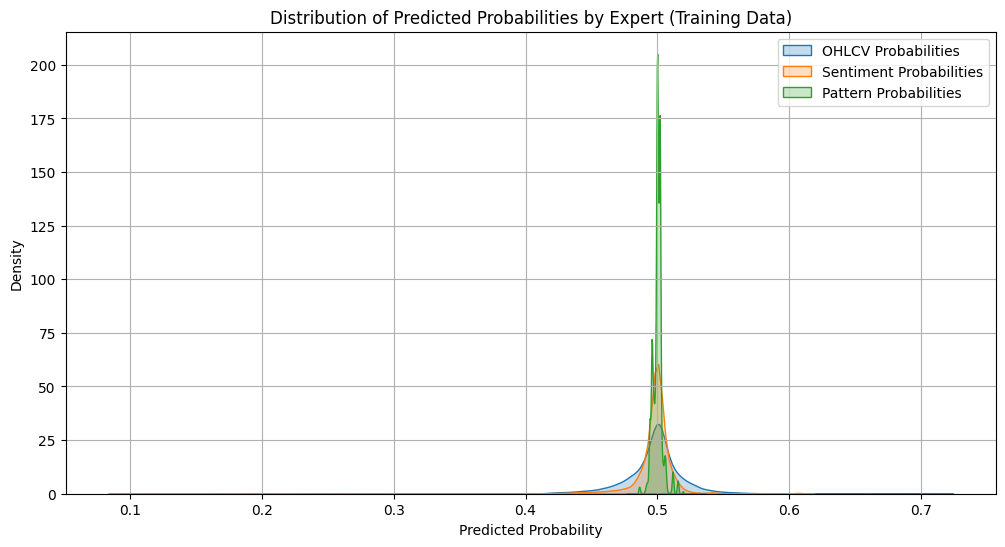

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(meta_train['p_ohlcv'], label='OHLCV Probabilities', fill=True)
sns.kdeplot(meta_train['p_sent'], label='Sentiment Probabilities', fill=True)
sns.kdeplot(meta_train['p_pat'], label='Pattern Probabilities', fill=True)
plt.title('Distribution of Predicted Probabilities by Expert (Training Data)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

This plot visualizes the distribution of predicted probabilities from each expert on the training data. You can observe the range and concentration of probabilities for OHLCV, sentiment, and pattern models, providing insights into their respective signal strengths and biases.

### 10.1) Figure 0: Create the probability series (single source of truth)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

def clip01(p, eps=1e-4):
    return np.clip(np.asarray(p, dtype=float), eps, 1.0 - eps)

# ---- Define the models to compare ----
W_OHLCV, W_SENT, W_PAT = 0.78, 0.0, 0.22  # your best VAL weights

# VAL probs
p_ohlcv_val = clip01(meta_val["p_ohlcv"].values)
p_pat_val   = clip01(meta_val["p_pat"].values)
p_blend_val = clip01(W_OHLCV*p_ohlcv_val + W_SENT*clip01(meta_val["p_sent"].values) + W_PAT*p_pat_val)

# TEST probs
p_ohlcv_test = clip01(meta_test["p_ohlcv"].values)
p_pat_test   = clip01(meta_test["p_pat"].values)
p_blend_test = clip01(W_OHLCV*p_ohlcv_test + W_SENT*clip01(meta_test["p_sent"].values) + W_PAT*p_pat_test)

y_val  = np.asarray(y_meta_val.values, dtype=int)
y_test = np.asarray(y_meta_test.values, dtype=int)

print("Prepared prob vectors:",
      "VAL", len(y_val), "TEST", len(y_test))

Prepared prob vectors: VAL 5208 TEST 5061


### 10.2) Figure 1: Metric comparison bar chart (VAL and TEST)

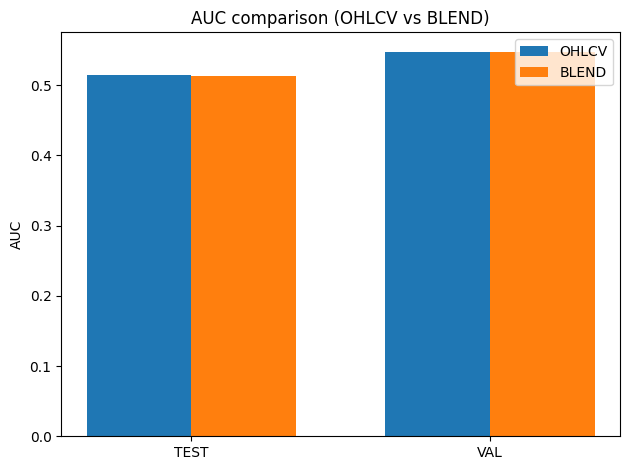

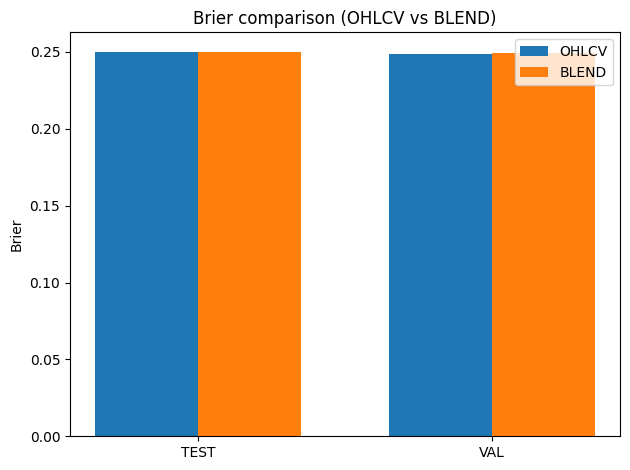

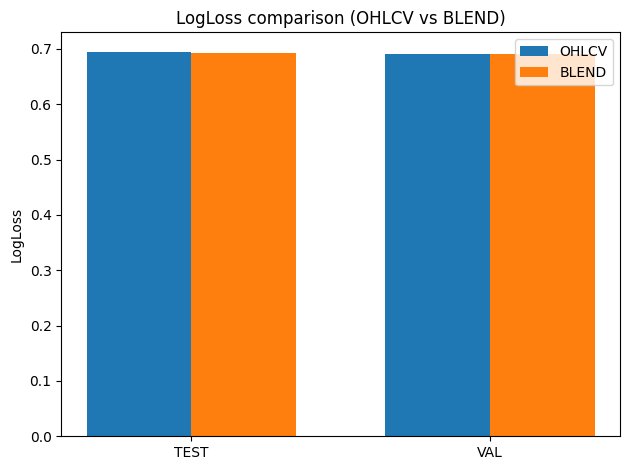

In [33]:
def metrics(y, p):
    return {
        "AUC": roc_auc_score(y, p),
        "Brier": brier_score_loss(y, p),
        "LogLoss": log_loss(y, p),
    }

m_val_ohlcv  = metrics(y_val, p_ohlcv_val)
m_val_blend  = metrics(y_val, p_blend_val)
m_test_ohlcv = metrics(y_test, p_ohlcv_test)
m_test_blend = metrics(y_test, p_blend_test)

# Build dataframe for plotting
df_plot = pd.DataFrame([
    {"Split":"VAL",  "Model":"OHLCV", "AUC":m_val_ohlcv["AUC"],  "Brier":m_val_ohlcv["Brier"],  "LogLoss":m_val_ohlcv["LogLoss"]},
    {"Split":"VAL",  "Model":"BLEND", "AUC":m_val_blend["AUC"],  "Brier":m_val_blend["Brier"],  "LogLoss":m_val_blend["LogLoss"]},
    {"Split":"TEST", "Model":"OHLCV", "AUC":m_test_ohlcv["AUC"], "Brier":m_test_ohlcv["Brier"], "LogLoss":m_test_ohlcv["LogLoss"]},
    {"Split":"TEST", "Model":"BLEND", "AUC":m_test_blend["AUC"], "Brier":m_test_blend["Brier"], "LogLoss":m_test_blend["LogLoss"]},
])

# Plot as three separate charts (cleaner for thesis)
for metric_name in ["AUC", "Brier", "LogLoss"]:
    plt.figure()
    # pivot for grouped bars
    piv = df_plot.pivot(index="Split", columns="Model", values=metric_name)
    x = np.arange(len(piv.index))
    width = 0.35

    plt.bar(x - width/2, piv["OHLCV"].values, width, label="OHLCV")
    plt.bar(x + width/2, piv["BLEND"].values, width, label="BLEND")

    plt.xticks(x, piv.index)
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} comparison (OHLCV vs BLEND)")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 10.3) Figure 2: Calibration curve (VAL and TEST)

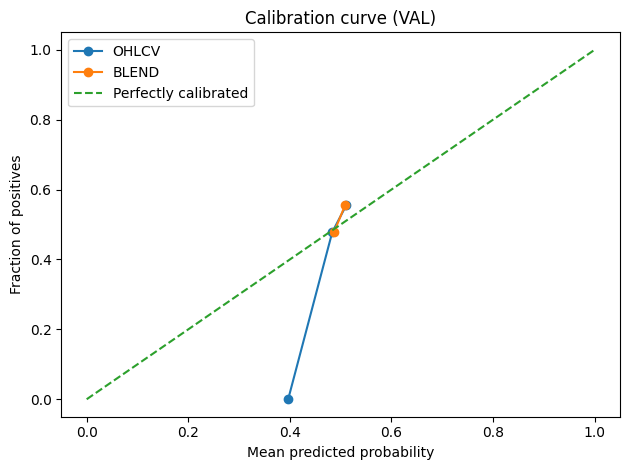

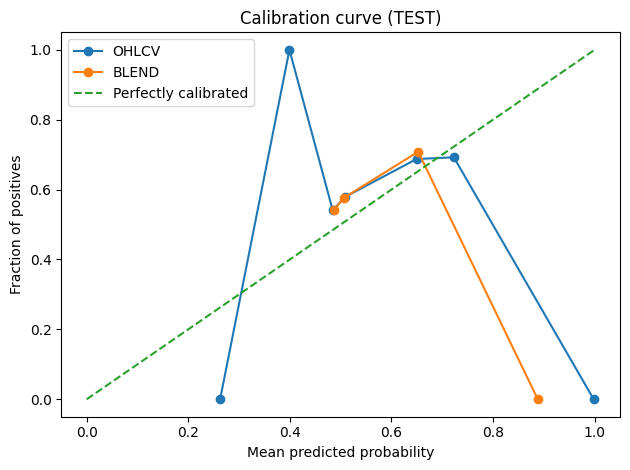

In [34]:
def plot_calibration(y, probs_dict, title):
    plt.figure()
    for name, p in probs_dict.items():
        frac_pos, mean_pred = calibration_curve(y, clip01(p), n_bins=10, strategy="uniform")
        plt.plot(mean_pred, frac_pos, marker="o", label=name)

    plt.plot([0,1],[0,1], linestyle="--", label="Perfectly calibrated")
    plt.title(title)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_calibration(
    y_val,
    {"OHLCV": p_ohlcv_val, "BLEND": p_blend_val},
    "Calibration curve (VAL)"
)

plot_calibration(
    y_test,
    {"OHLCV": p_ohlcv_test, "BLEND": p_blend_test},
    "Calibration curve (TEST)"
)

### 10.4) Figure 3: Probability distribution (histogram) showing tail compression

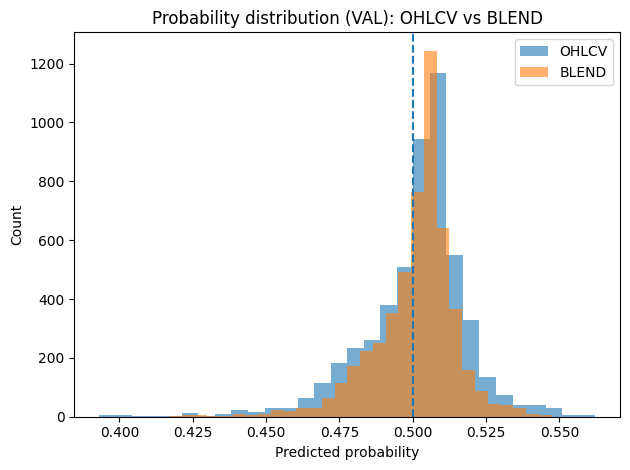

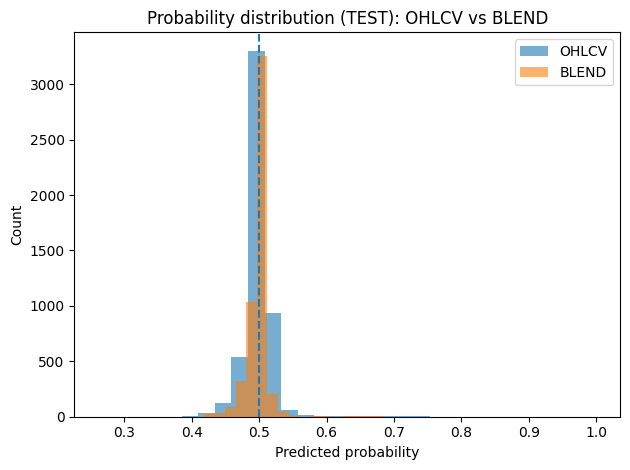

In [35]:
def plot_prob_hist(p1, p2, title, bins=30):
    plt.figure()
    plt.hist(clip01(p1), bins=bins, alpha=0.6, label="OHLCV")
    plt.hist(clip01(p2), bins=bins, alpha=0.6, label="BLEND")
    plt.axvline(0.5, linestyle="--")
    plt.title(title)
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_prob_hist(p_ohlcv_val,  p_blend_val,  "Probability distribution (VAL): OHLCV vs BLEND")
plot_prob_hist(p_ohlcv_test, p_blend_test, "Probability distribution (TEST): OHLCV vs BLEND")

These histograms visualize the distribution of predicted probabilities from the OHLCV model and the blended fusion model. You can observe a "tail compression" effect in the blended model, where extreme probabilities (close to 0 or 1) are less frequent compared to the OHLCV model. This indicates that the fusion model tends to be less overconfident, distributing probabilities more centrally around 0.5, especially during ambiguous periods.

## 10.5) Figure 4: Overconfidence stress test (logloss by confidence bucket)

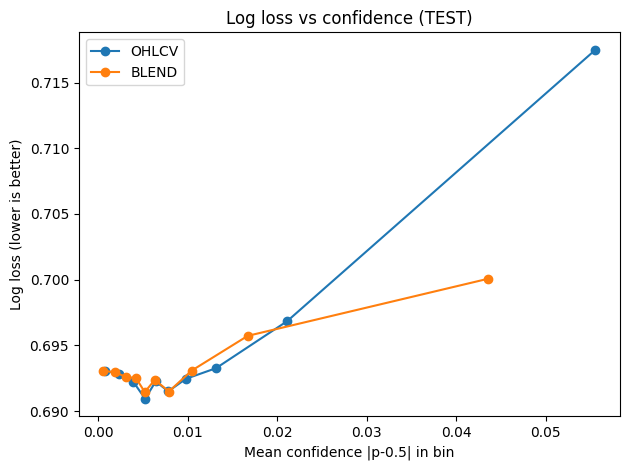

In [36]:
def logloss_by_confidence(y, p, n_bins=10):
    y = np.asarray(y, dtype=int)
    p = clip01(p)
    conf = np.abs(p - 0.5)

    # bin by confidence quantiles
    qs = np.quantile(conf, np.linspace(0, 1, n_bins+1))
    rows = []
    for i in range(n_bins):
        lo, hi = qs[i], qs[i+1]
        idx = (conf >= lo) & (conf <= hi) if i == n_bins-1 else (conf >= lo) & (conf < hi)
        if idx.sum() < 10:
            continue
        rows.append({
            "bin": i+1,
            "coverage": float(idx.mean()),
            "conf_mean": float(conf[idx].mean()),
            "logloss": float(log_loss(y[idx], p[idx])),
            "count": int(idx.sum())
        })
    return pd.DataFrame(rows)

df_ll_ohlcv = logloss_by_confidence(y_test, p_ohlcv_test, n_bins=10)
df_ll_blend = logloss_by_confidence(y_test, p_blend_test, n_bins=10)

plt.figure()
plt.plot(df_ll_ohlcv["conf_mean"], df_ll_ohlcv["logloss"], marker="o", label="OHLCV")
plt.plot(df_ll_blend["conf_mean"], df_ll_blend["logloss"], marker="o", label="BLEND")
plt.title("Log loss vs confidence (TEST)")
plt.xlabel("Mean confidence |p-0.5| in bin")
plt.ylabel("Log loss (lower is better)")
plt.legend()
plt.tight_layout()
plt.show()

## 11) MLflow Logging & Registration

In [ ]:
# ---- MLflow logging + registration for meta-model ----
import mlflow
from mlflow.models.signature import infer_signature

mlflow.sklearn.autolog(disable=True)

run_name = f"stacked_meta_lr_multisym_{meta_ohlcv.get('start_year','2019')}_{meta_ohlcv.get('end_year','2023')}_h{horizon_days}d_gated"
with mlflow.start_run(run_name=run_name):
    mlflow.set_tag("stacking_inputs", "p_ohlcv,p_sent,p_pat")
    mlflow.set_tag("horizon_days", str(horizon_days))
    mlflow.set_tag("model_ohlcv_uri", uri_ohlcv)
    mlflow.set_tag("model_sent_uri", uri_sent)
    mlflow.set_tag("model_pat_uri", uri_pat)

    mlflow.log_params({
        "meta_C": best_params["C"],
        "meta_penalty": best_params["penalty"],
        "meta_class_weight": best_params["class_weight"],
    })

    mlflow.log_metrics({**val_metrics, **test_metrics})

    rank.to_csv("meta_val_candidate_ranking.csv", index=False)
    mlflow.log_artifact("meta_val_candidate_ranking.csv", artifact_path="model_selection")

    input_example = meta_train.head(5)
    sig = infer_signature(input_example, final_meta.predict_proba(input_example)[:, 1])

    mlflow.sklearn.log_model(
        sk_model=final_meta,
        artifact_path="model_final",
        input_example=input_example,
        signature=sig,
    )

    # Register
    model_name = "fusion_meta_lr_multisym"
    mv = mlflow.register_model(f"runs:/{mlflow.active_run().info.run_id}/model_final", model_name)
    print("Registered model version:", mv.version)


Successfully registered model 'fusion_meta_lr_multisym'.
2026/01/31 10:43:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: fusion_meta_lr_multisym, version 1
Created version '1' of model 'fusion_meta_lr_multisym'.


Registered model version: 1
🏃 View run stacked_meta_lr_multisym_2019_2023_h5d_gated at: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow/#/experiments/9/runs/a445a38dc43347dea558483e10c77b6d
🧪 View experiment at: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow/#/experiments/9
